In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
from datetime import datetime
import calendar

warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', 500)

In [3]:
#load fraudulent profile 1375
badguy_1 = pd.read_excel('/Users/AngelicaGoglio/Documents/GitHub/Cases/Case7/Case7.xlsx')
badguy_1["date"] = badguy_1["day"] +['-']+ badguy_1["time"]
badguy_2 = badguy_1.rename(columns={"power": "power_real", "FD5": "power_fraud"})
badguy_3=badguy_2.drop(['day','time','Unnamed: 0','smart meter'], axis=1)
badguy_3['date'] = pd.to_datetime(badguy_3['date'],format='%Y-%m-%d-%H:%M')
print (badguy_3)

      power_real  power_fraud                date
0          0.137        0.137 2020-06-02 00:00:00
1          0.137        0.137 2020-06-02 01:00:00
2          0.135        0.135 2020-06-02 02:00:00
3          0.453        0.453 2020-06-02 03:00:00
4          0.379        0.379 2020-06-02 04:00:00
...          ...          ...                 ...
3644       0.896        0.896 2020-10-31 19:00:00
3645       1.146        1.146 2020-10-31 20:00:00
3646       1.112        1.112 2020-10-31 21:00:00
3647       1.510        1.510 2020-10-31 22:00:00
3648       1.826        1.826 2020-10-31 23:00:00

[3649 rows x 3 columns]


In [4]:
badguy_3.dtypes

power_real            float64
power_fraud           float64
date           datetime64[ns]
dtype: object

In [5]:
#SELECT SMALLER DATASET
badguy = badguy_3[:720]
print(badguy)

     power_real  power_fraud                date
0         0.137        0.137 2020-06-02 00:00:00
1         0.137        0.137 2020-06-02 01:00:00
2         0.135        0.135 2020-06-02 02:00:00
3         0.453        0.453 2020-06-02 03:00:00
4         0.379        0.379 2020-06-02 04:00:00
..          ...          ...                 ...
715       0.860        0.860 2020-07-01 19:00:00
716       0.605        0.605 2020-07-01 20:00:00
717       1.102        1.102 2020-07-01 21:00:00
718       0.698        0.698 2020-07-01 22:00:00
719       1.234        1.234 2020-07-01 23:00:00

[720 rows x 3 columns]


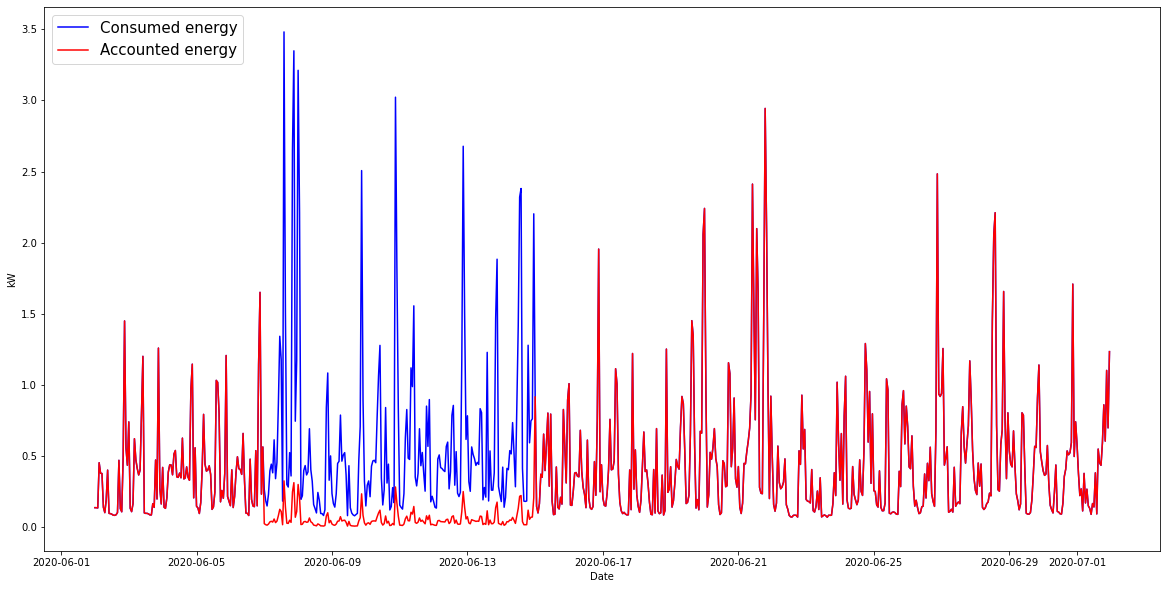

In [6]:
plt.figure(figsize=(20,10))
plt.plot(badguy['date'], badguy['power_real'], 'b', label='Consumed energy')
plt.plot(badguy['date'], badguy['power_fraud'], 'r', label='Accounted energy')
plt.xlabel('Date')
plt.ylabel('kW')
plt.legend(loc="upper left", prop={'size': 15})
plt.show()

In [7]:
df_bg=badguy.copy()

df_bg['day'] = df_bg['date'].apply(lambda x:x.strftime('%Y%m%d'))

df_bg['time'] = df_bg['date'].apply(lambda x:x.strftime('%H:%M'))

df_bg = df_bg.drop(['date', 'power_real'], axis=1)
df_bg.head()

,power_fraud,day,time
0,0.137,20200602,00:00
1,0.137,20200602,01:00
2,0.135,20200602,02:00
3,0.453,20200602,03:00
4,0.379,20200602,04:00


# Approach 1
### K-Means + Artificial Features

In [8]:
list_days=df_bg['day'].unique()
list_days

array(['20200602', '20200603', '20200604', '20200605', '20200606',
       '20200607', '20200608', '20200609', '20200610', '20200611',
       '20200612', '20200613', '20200614', '20200615', '20200616',
       '20200617', '20200618', '20200619', '20200620', '20200621',
       '20200622', '20200623', '20200624', '20200625', '20200626',
       '20200627', '20200628', '20200629', '20200630', '20200701'],
      dtype=object)

In [9]:
#How many different days are there?
n=df_bg['day'].nunique()
n

30

In [10]:
df_cluster=df_bg.copy()

In [11]:
#CUTS FUNCTION
def cuts(df,mean):
    power = df.iloc[0]['power_fraud']
    above = True
    above_0 = (power>mean)
    prev_above = above_0
    cuts = 0
    i=0
    for index, row in df.iterrows():
        if i!=0:
            power = row['power_fraud']
            above = power>mean
            if above!=prev_above:
                cuts += 1
                above = (power>mean)
            prev_above=above
            i+=1
        else:
            i+=1
    if above_0!=above:
        cuts += 1    
    return (cuts)

In [12]:
#SLOPES FUNCTION
def deep_slopes(df, mean):
    power = df.iloc[0]['power_fraud']
    previous_p = power
    inc = 0
    dec = 0
    power_0 = power
    for index, row in df.iterrows():
        #print(power, inc, dec)
        power = row['power_fraud']
        if power>(previous_p+0.5*mean):
            inc += 1
        elif power<(previous_p-0.5*mean):
            dec += 1
        previous_p = power
    if power_0>(previous_p+0.5*mean):
        inc += 1
    elif power_0>(previous_p-0.5*mean):
        dec += 1
    return (inc,dec)

In [13]:
def find_peaks(day, nb_samples):
    daily_max_function = []
    
    for i in range(2,23):    #Look at the second day and the second last one so I can compare i-1, i, i+1
        if i==23 and day[i+1]>day[i]:
            daily_max_function.append(day[i+1])
        if day[i]>day[i-1] and day[i]>day[i+1]:
            daily_max_function.append(day[i])
            
    daily_max_function.sort(reverse = True)
    final_average = sum(daily_max_function[0:nb_samples])/nb_samples
    return(final_average)

In [14]:
df_cluster

,power_fraud,day,time
0,0.137,20200602,00:00
1,0.137,20200602,01:00
2,0.135,20200602,02:00
3,0.453,20200602,03:00
4,0.379,20200602,04:00
...,...,...,...
715,0.860,20200701,19:00
716,0.605,20200701,20:00
717,1.102,20200701,21:00
718,0.698,20200701,22:00


In [15]:
#FEATURES SELECTION
df = pd.DataFrame(columns=['date','mean','median','std','max', 'min', 'mean_p1','mean_p2','mean_p3','n_cuts','inc','dec','peaks_avg'])
meter_stat = pd.DataFrame(columns=['mean','median','std','max','min','mean_p1','mean_p2','mean_p3','n_cuts','inc','dec', 'peaks_avg'])

df_cluster['datetime'] =  pd.to_datetime(df_cluster['time'], format='%H:%M')

for day in list_days:
    daily_ref = df_cluster[df_cluster['day'] == day]
    
    mean = daily_ref['power_fraud'].mean()
    
    median = daily_ref['power_fraud'].median()
    
    std = daily_ref['power_fraud'].std()
    
    maxim = daily_ref['power_fraud'].max()
    
    minim = daily_ref['power_fraud'].min()
    
    daily_p1 = daily_ref[daily_ref['datetime'].dt.hour < 8]
    mean_p1 = daily_p1['power_fraud'].mean()
    
    daily_p2 = daily_ref[(daily_ref['datetime'].dt.hour > 8) & (daily_ref['datetime'].dt.hour < 16)]
    mean_p2 = daily_p2['power_fraud'].mean()
    
    daily_p3 = daily_ref[(daily_ref['datetime'].dt.hour > 16) & (daily_ref['datetime'].dt.hour < 24)]
    mean_p3 = daily_p3['power_fraud'].mean()
    
    n_cuts = cuts(daily_ref,mean)
    
    inc, dec = deep_slopes(daily_ref,mean)
    
    peak = find_peaks(list(daily_ref['power_fraud']), 2)
    
    df = df.append({'date':day,'mean':mean,'std':std, 'median':median, 'max': maxim, 'min': minim, 'mean_p1':mean_p1, 
                    'mean_p2':mean_p2, 'mean_p3':mean_p3, 'n_cuts':n_cuts, 'inc':inc, 'dec':dec, 'peaks_avg':peak},
                   ignore_index=True)
    
df_features=df
df_features.head()

,date,mean,median,std,max,min,mean_p1,mean_p2,mean_p3,n_cuts,inc,dec,peaks_avg
0,20200602,0.280542,0.1370,0.297485,1.450,0.083,0.232500,0.134000,0.519857,8,5,4,0.9600
1,20200603,0.360292,0.1815,0.341725,1.259,0.086,0.377750,0.352571,0.381571,8,6,4,1.2300
2,20200604,0.429417,0.3740,0.229021,1.146,0.132,0.316250,0.419286,0.568714,10,3,4,0.8860
3,20200605,0.407167,0.3150,0.321833,1.207,0.096,0.323375,0.480857,0.374286,8,4,6,1.1195
4,20200606,0.395417,0.3500,0.359119,1.651,0.082,0.325625,0.277000,0.632286,14,7,6,1.1550


In [16]:
df_features = df_features.set_index('date')

In [17]:
df_features.isnull().any().any()

False

In [18]:
# Importing StandardScaler method for SkLearn 
from sklearn.preprocessing import StandardScaler

# Creating the instance for Standard Scaler 
scaler = StandardScaler()

# Fitting the scaler with meter_stat
scaler.fit(df_features)

# Transforming the meter_stat df into an scaled one. 
df_features_scaled = pd.DataFrame(scaler.transform(df_features), index=df_features.index, columns=df_features.columns)

In [19]:
df_features_scaled.head(10)

,mean,median,std,max,min,mean_p1,mean_p2,mean_p3,n_cuts,inc,dec,peaks_avg
date,,,,,,,,,,,,
20200602,-0.259277,-0.684110,0.064677,0.360304,0.220504,-0.211053,-0.589956,0.180365,0.147764,-0.049752,-0.500000,0.098132
20200603,0.125551,-0.411651,0.311155,0.100580,0.294558,0.665842,0.182248,-0.288863,0.147764,0.696526,-0.500000,0.571220
20200604,0.459108,0.766962,-0.316767,-0.053078,1.430039,0.294558,0.417947,0.346146,1.034345,-1.542308,-0.500000,-0.031529
20200605,0.351743,0.405725,0.200327,0.029870,0.541401,0.337572,0.635476,-0.313585,0.147764,-0.796030,1.166667,0.377604
20200606,0.295044,0.620018,0.408063,0.633626,0.195820,0.351156,-0.084743,0.561855,2.807507,1.442804,1.166667,0.439807
20200607,-1.210834,-1.265802,-1.090546,-1.169076,-1.484691,-1.426592,-0.638113,-1.172270,0.147764,-0.796030,-0.500000,-1.024861
20200608,-1.372148,-1.336157,-1.212632,-1.203376,-1.639200,-1.090865,-0.990241,-1.445299,-0.738818,-1.542308,-0.500000,-1.438598
20200609,-1.418826,-1.325290,-1.331754,-1.292938,-1.643812,-1.407416,-0.982037,-1.353278,-0.738818,-0.049752,1.166667,-1.314272
20200610,-1.337305,-1.301552,-1.249351,-1.227386,-1.549262,-1.417215,-0.862555,-1.293727,-0.738818,-1.542308,0.333333,-1.231934


In [20]:
#Drop not a number values
df_features_scaled=df_features_scaled.dropna()
df_features=df_features.dropna()
df_features_db=df_features_scaled
nan_rows = df_features_scaled[df_features_scaled.isnull().any(1)]
nan_rows

,mean,median,std,max,min,mean_p1,mean_p2,mean_p3,n_cuts,inc,dec,peaks_avg
date,,,,,,,,,,,,


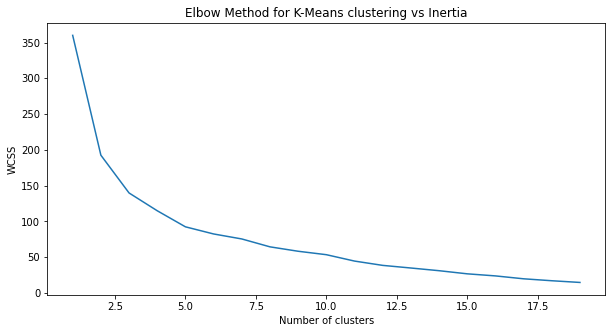

In [21]:
# Importing the library for KMeans 
from sklearn.cluster import KMeans

# Creating an empty list 
wcss = []

#ELBOW METHOD
# Creating a for loop for clusters between 1 and 12. 
# We create an instance, we fit the model and calculate the inertia 
for i in range(1, 20):
    kmeans = KMeans(n_clusters = i, init = "k-means++", max_iter = 300, n_init = 10, random_state = 42)
    kmeans.fit(df_features_scaled)
    wcss.append (kmeans.inertia_)
# Plotting the inertia in front of each iteration 
plt.figure(figsize=(10,5))
plt.plot(range(1, 20), wcss)

# Setting aesthetics of the plot. 
plt.title('Elbow Method for K-Means clustering vs Inertia')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

plt.show()

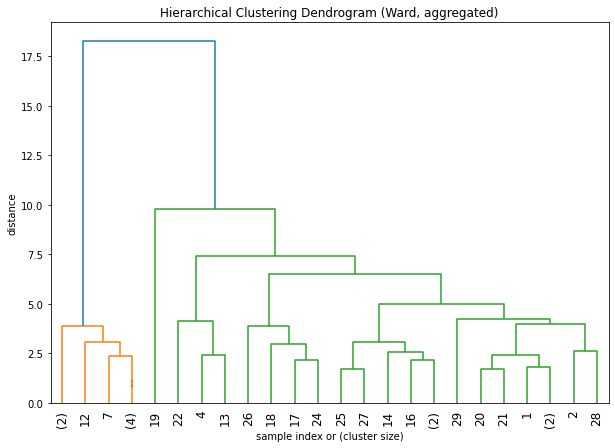

In [22]:
#DENDOGRAM METHOD

# Hierarchical algorithm for clustering. Import hierarchical algorithm method. 
from scipy.cluster.hierarchy import dendrogram, linkage

# Creating a new hierarchical algorithm  
linkage_matrix = linkage(df_features_scaled, 'ward')

# Creating the figure 
figure = plt.figure(figsize=(10, 7))

# The hierarchical algorithm will be reduced, only showing the converged clusters.
dendrogram(
    linkage_matrix,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=24,                   # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,   # to get a distribution impression in truncated branches
)

# Setting aesthetics of the plot 
plt.title('Hierarchical Clustering Dendrogram (Ward, aggregated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
plt.show()

In [23]:
#CLUSTERING
# We assume 2 clusters 
kmeans = KMeans(n_clusters=2)

# Fitting the input data
kmeans.fit(df_features_scaled)

# Including the labels in the database 
df_features['labels'] = kmeans.labels_

In [24]:
# Counting the number of clients under each label. 
df_features['labels'].value_counts()

0    22
1     8
Name: labels, dtype: int64

In [25]:
print(f"The inertia of the model with k=2 is {kmeans.inertia_}")

The inertia of the model with k=2 is 192.47036628565056


In [26]:
df_features['labels']

date
20200602    0
20200603    0
20200604    0
20200605    0
20200606    0
20200607    1
20200608    1
20200609    1
20200610    1
20200611    1
20200612    1
20200613    1
20200614    1
20200615    0
20200616    0
20200617    0
20200618    0
20200619    0
20200620    0
20200621    0
20200622    0
20200623    0
20200624    0
20200625    0
20200626    0
20200627    0
20200628    0
20200629    0
20200630    0
20200701    0
Name: labels, dtype: int32

In [27]:
v_label=[]
for ind in df_cluster.index:
    date = df_cluster['day'][ind]
    if date in df_features.index:
        v_label=v_label+[df_features['labels'][date]]
    else:
        v_label=v_label+['NaN']
df_cluster['label']=v_label
df_cluster.head()

,power_fraud,day,time,datetime,label
0,0.137,20200602,00:00,1900-01-01 00:00:00,0
1,0.137,20200602,01:00,1900-01-01 01:00:00,0
2,0.135,20200602,02:00,1900-01-01 02:00:00,0
3,0.453,20200602,03:00,1900-01-01 03:00:00,0
4,0.379,20200602,04:00,1900-01-01 04:00:00,0


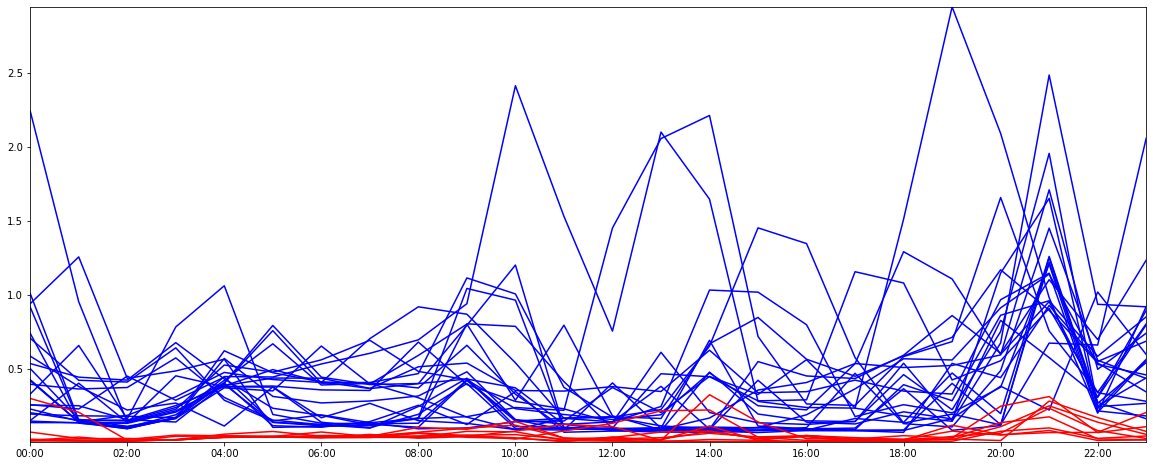

In [28]:
list_labels = df_cluster['label'].unique()
plt.figure(figsize=(20,8))

for label in list_labels:
    df_label = df_cluster.loc[df_cluster['label']==label]
    list_dates = df_label['day'].unique()
    for date in list_dates:
        df_label_date = df_label.loc[df_label['day']==date]
        if label==0:
            plt.plot(df_label_date['time'],df_label_date['power_fraud'],'b')
        else:
            plt.plot(df_label_date['time'],df_label_date['power_fraud'],'r')

plt.xticks(np.arange(0, 48, step=2))
plt.margins(x=0, y=0)
plt.show()        